In [20]:
!pip3 cache purge
!pip3 install --no-cache-dir --upgrade jupyter ipywidgets
!pip3 install --no-cache-dir umap-learn
!pip3 install pandas matplotlib scikit-learn seaborn numpy scipy

Files removed: 0


In [21]:
from scipy.stats import ks_2samp, wasserstein_distance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import umap

# 1. Análise inicial e tratamento dos datasets

In [22]:
data1 = pd.read_csv('data1.csv', header=None)
data2 = pd.read_csv('data2.csv', header=None)
data3 = pd.read_csv('data3.csv', header=None)

data1.columns = ['timestamp', 'idade', 'id_paciente', 'sexo', 'exame', 'resultado']
data2.columns = ['timestamp', 'idade', 'id_paciente', 'sexo', 'exame', 'resultado']
data3.columns = ['timestamp', 'idade', 'id_paciente', 'sexo', 'exame', 'resultado']

data1.drop(columns=['timestamp', 'id_paciente'], inplace=True)
data2.drop(columns=['timestamp', 'id_paciente'], inplace=True)
data3.drop(columns=['timestamp', 'id_paciente'], inplace=True)

data1.dropna(inplace=True)
data2.dropna(inplace=True)
data3.dropna(inplace=True)

data1.reset_index(drop=True, inplace=True)
data2.reset_index(drop=True, inplace=True)
data3.reset_index(drop=True, inplace=True)

for df_name in ['data1', 'data2', 'data3']:
    df = locals()[df_name]
    df['resultado'] = (
        df['resultado']
        .astype(str)
        .str.replace('"', '', regex=False)
        .str.replace("'", '', regex=False)
        .str.strip()
        .str.replace(',', '.')
    )
    # Remove linhas sem valor válido para resultado
    df = df[df['resultado'].str.strip() != '']
    df.reset_index(drop=True, inplace=True)
    locals()[df_name] = df

for i, row in data1.iterrows():
    if row['resultado'] == '':
        print(f"Linha com resultado vazio encontrada no índice {i}: {row}")

In [23]:
exames_df = pd.DataFrame({
    'data1': data1['exame'].value_counts(),
    'data2': data2['exame'].value_counts(),
    'data3': data3['exame'].value_counts()
}).fillna(0).astype(int)

exames_df.index.name = "Tipo de Exame"
exames_df.columns = ["Nº de ocorrências (data1)", "Nº de ocorrências (data2)", "Nº de ocorrências (data3)"]

display(exames_df)

,Nº de ocorrências (data1),Nº de ocorrências (data2),Nº de ocorrências (data3)
Tipo de Exame,,,
EOSINÓFILOS ABSOLUTO,810,1188,1319
LEUCÓCITOS TOTAIS,0,1188,0
LINFOCITOS ATIPICOS TOTAL %,1,1,1
LINFÓCITOS %,12094,27163,23930
LINFÓCITOS ABSOLUTO,12096,27265,23932
LUC %,0,1187,0
LUC ABSOLUTO,0,1188,0
MCHC,811,1188,1318
NEUTRÓFILOS %,11284,25974,22611


Como sugerido no enunciado, será adotada a simplificação de apenas sintetizar dados de um dos tipos de exames. 

Neste caso, o exame escolhido foi o PLAQUETAS SANGUE, já que é o que possui mais ocorrências. Desta forma, podemos obter maior realismo no dataset sintético.

In [24]:
data1 = data1[data1['exame'].isin(["PLAQUETAS SANGUE"])].reset_index(drop=True)
data2 = data2[data2['exame'].isin(["PLAQUETAS SANGUE"])].reset_index(drop=True)
data3 = data3[data3['exame'].isin(["PLAQUETAS SANGUE"])].reset_index(drop=True)

data1 = data1.drop(columns=['exame'])
data2 = data2.drop(columns=['exame'])
data3 = data3.drop(columns=['exame'])

# Encoding das variáveis categóricas F -> 0, M -> 1
le = LabelEncoder()
data1.loc[:, 'sexo'] = le.fit_transform(data1['sexo'])
data2.loc[:, 'sexo'] = le.transform(data2['sexo'])
data3.loc[:, 'sexo'] = le.transform(data3['sexo'])

data1.head()

,idade,sexo,resultado
0,19,0,316.00
1,70,1,239.00
2,62,0,166.00
3,49,1,201.00
4,50,1,319.00


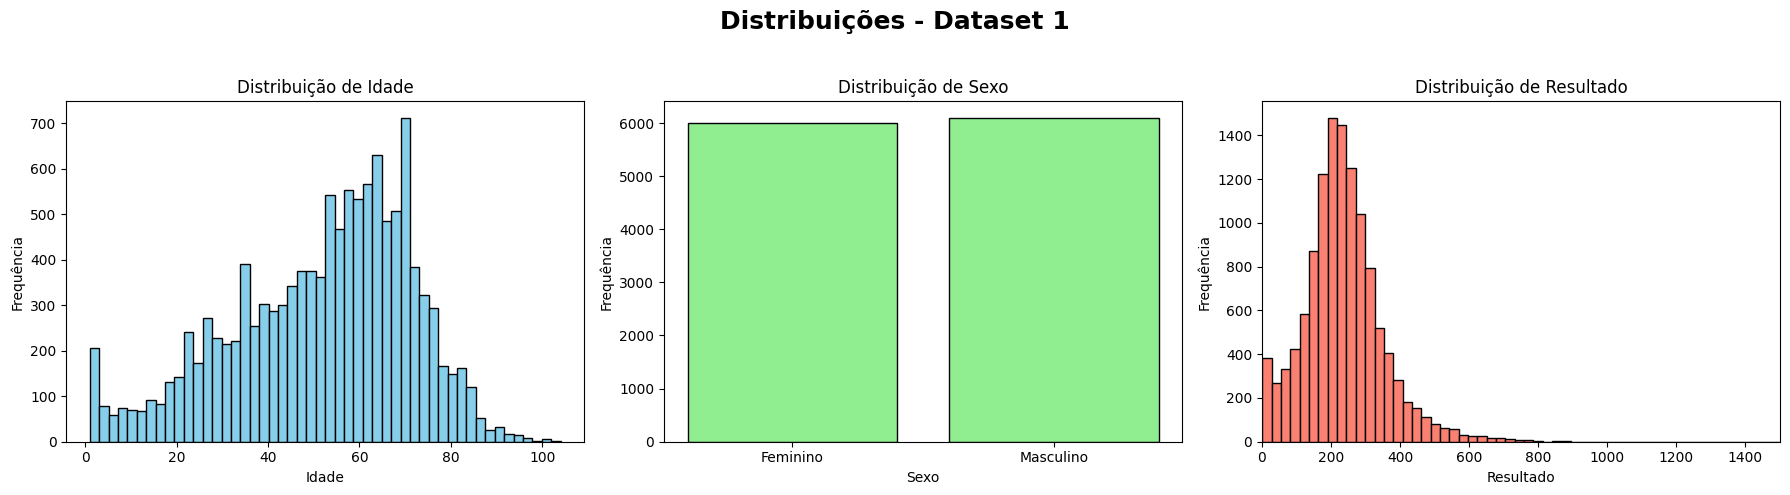

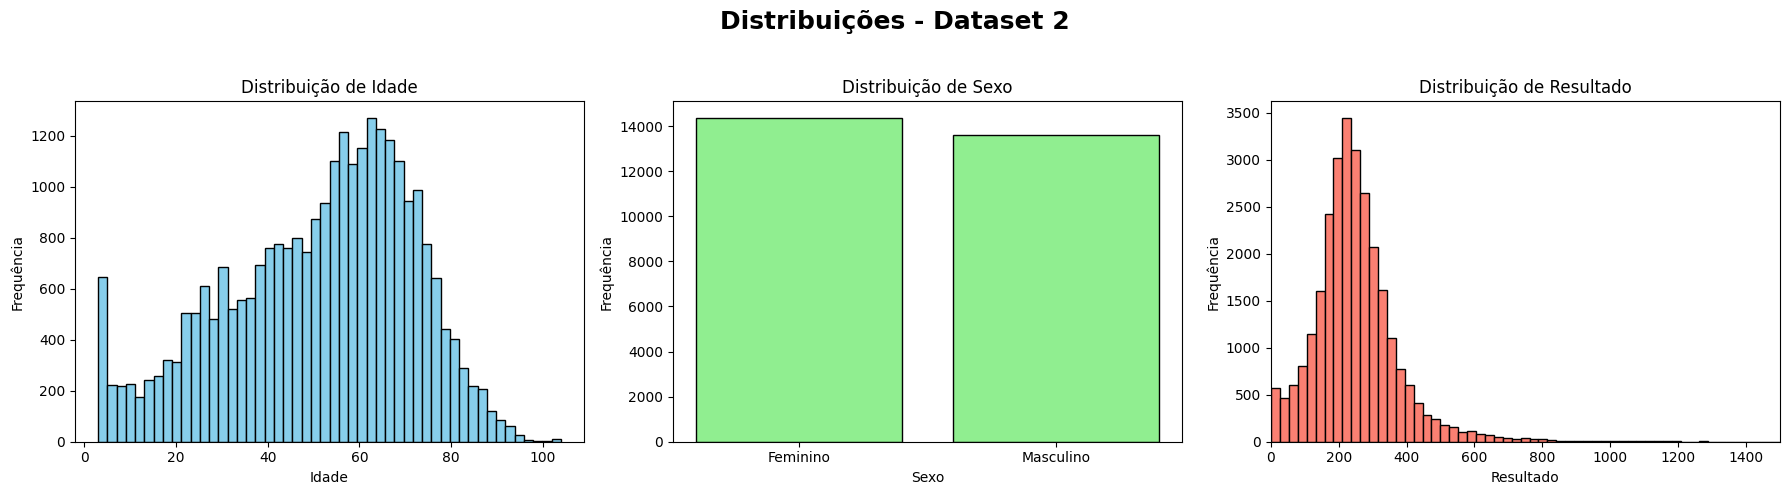

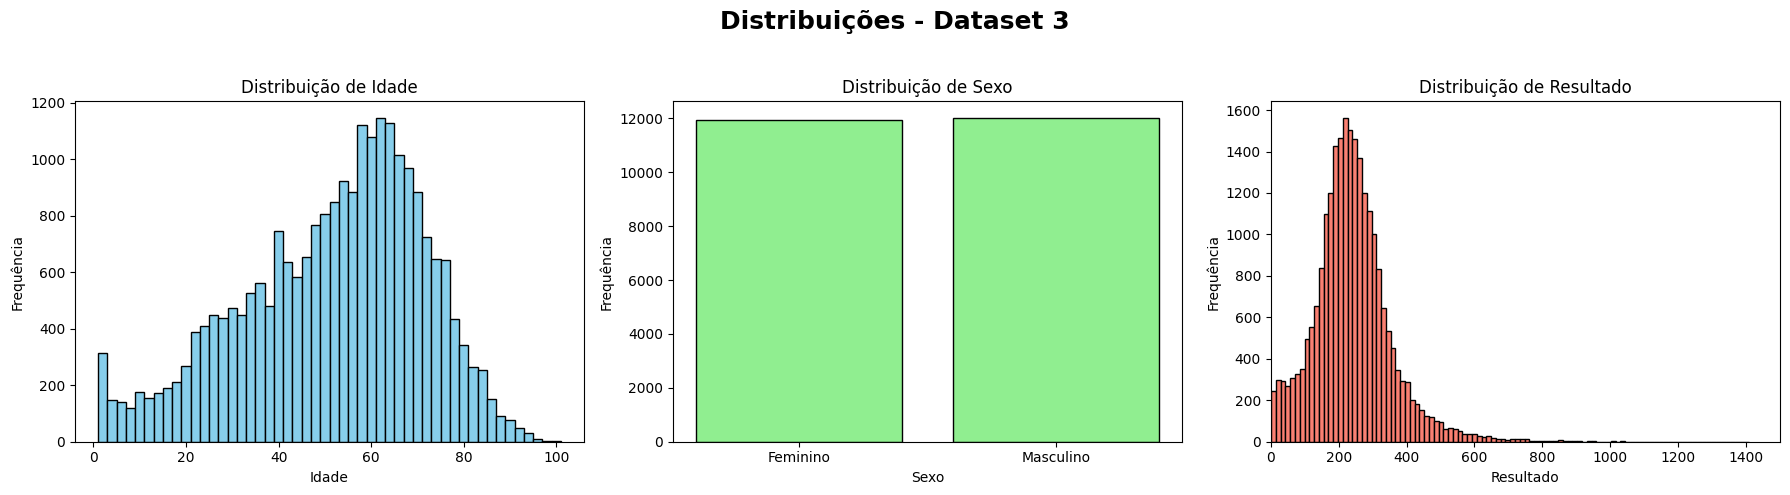

In [25]:
def plot_distributions(data, title):

    _, axes = plt.subplots(1, 3, figsize=(18, 5))

    axes[0].hist(data['idade'], bins=50, color='skyblue', edgecolor='black')
    axes[0].set_title('Distribuição de Idade')
    axes[0].set_xlabel('Idade')
    axes[0].set_ylabel('Frequência')

    sexo_counts = data['sexo'].value_counts().sort_index()
    axes[1].bar(['0', '1'], [sexo_counts.get(0, 0), sexo_counts.get(1, 0)], color='lightgreen', edgecolor='black')
    axes[1].set_title('Distribuição de Sexo')
    axes[1].set_xlabel('Sexo')
    axes[1].set_ylabel('Frequência')
    axes[1].set_xticks([0, 1])
    axes[1].set_xticklabels(['Feminino', 'Masculino'])

    resultado_float = data['resultado'].astype(float)
    axes[2].hist(resultado_float, bins=100, color='salmon', edgecolor='black')
    axes[2].set_title('Distribuição de Resultado')
    axes[2].set_xlabel('Resultado')
    axes[2].set_ylabel('Frequência')
    axes[2].set_xlim(0, 1500)

    plt.suptitle(title, fontsize=18, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_distributions(data1, "Distribuições - Dataset 1")
plot_distributions(data2, "Distribuições - Dataset 2")
plot_distributions(data3, "Distribuições - Dataset 3")

In [26]:
def print_stats_all_tables(data_list, names):

    idade_stats = []
    resultado_stats = []

    for data in data_list:
        idade_desc = data['idade'].describe()
        resultado_float = pd.to_numeric(data['resultado'])
        resultado_desc = resultado_float.describe()
        idade_stats.append(idade_desc)
        resultado_stats.append(resultado_desc)

    idade_df = pd.DataFrame(idade_stats, index=names).T
    resultado_df = pd.DataFrame(resultado_stats, index=names).T

    tabela_final = pd.concat([idade_df, resultado_df], keys=['Idade', 'Resultado'])
    display(tabela_final)

print_stats_all_tables([data1, data2, data3], ["data1", "data2", "data3"])  

data1         data2         data3
Idade     count  12104.000000  27971.000000  23986.000000
          mean      51.718027     51.082049     51.156049
          std       19.720020     20.248816     19.634748
          min        1.000000      3.000000      1.000000
          25%       39.000000     37.000000     38.000000
          50%       55.000000     55.000000     54.000000
          75%       66.000000     66.000000     66.000000
          max      104.000000    104.000000    101.000000
Resultado count  12104.000000  27971.000000  23986.000000
          mean     235.447455    250.145079    240.671744
          std      119.084161    126.720440    114.248473
          min        1.000000      1.000000      1.000000
          25%      167.750000    179.000000    174.000000
          50%      227.000000    237.000000    232.000000
          75%      292.000000    303.000000    296.000000
          max     2708.000000   2626.000000   1410.000000

/home/henrique/Documentos/grad/EA998/A1/.venv/lib/python3.10/site-packages/seaborn/categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)
/home/henrique/Documentos/grad/EA998/A1/.venv/lib/python3.10/site-packages/seaborn/categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)
/home/henrique/Documentos/grad/EA998/A1/.venv/lib/python3.10/site-packages/seaborn/categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


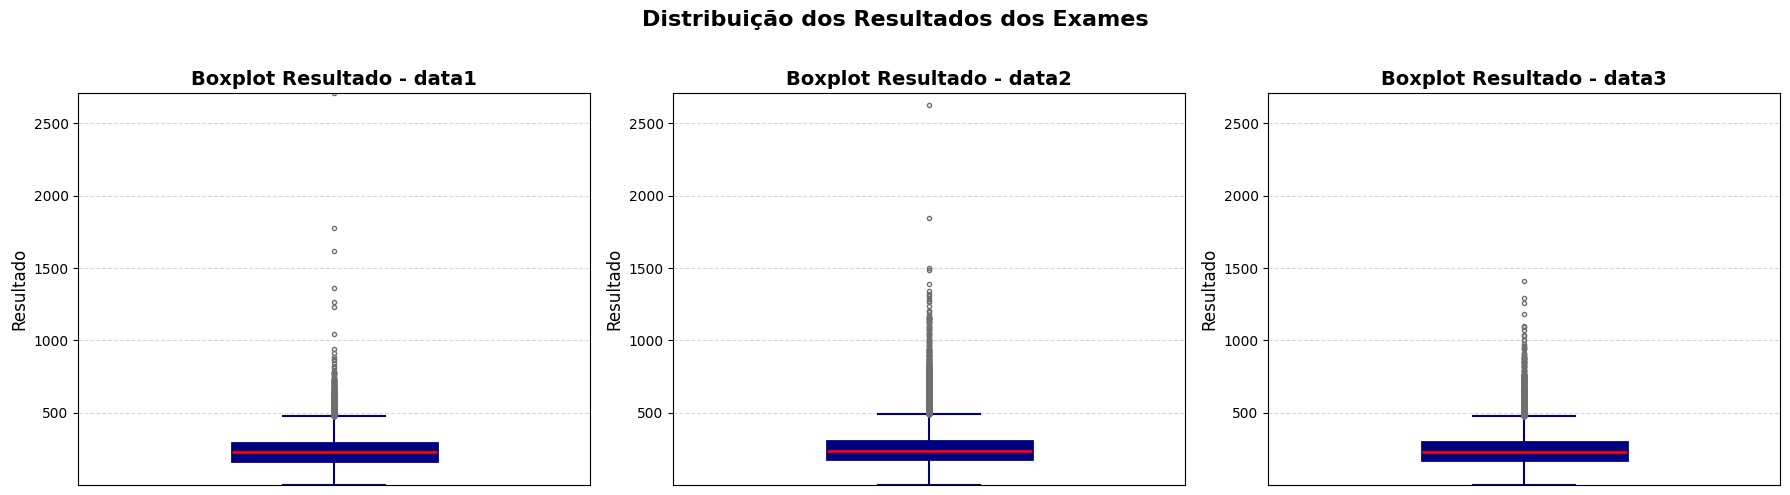

In [27]:
def plot_boxplots(datasets, nomes):

    plt.figure(figsize=(6 * len(datasets), 5))

    # máximo e mínimo para padronizar o eixo y
    all_results = pd.concat([
        pd.to_numeric(df['resultado']) for df in datasets
    ])
    ymin, ymax = all_results.min(), all_results.max()

    for idx, (df, nome) in enumerate(zip(datasets, nomes)):
        plt.subplot(1, len(datasets), idx + 1)
        resultado_float = pd.to_numeric(df['resultado'])
        sns.boxplot(
            y=resultado_float,
            color='skyblue',
            width=0.4,
            fliersize=3,
            linewidth=2,
            boxprops=dict(facecolor='lightyellow', color='navy'),
            medianprops=dict(color='red', linewidth=2),
            whiskerprops=dict(color='navy', linewidth=1.5),
            capprops=dict(color='navy', linewidth=1.5)
        )
        plt.title(f'Boxplot Resultado - {nome}', fontsize=14, fontweight='bold')
        plt.ylabel('Resultado', fontsize=12)
        plt.ylim(ymin, ymax)
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.xticks([])

    plt.suptitle('Distribuição dos Resultados dos Exames', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_boxplots([data1, data2, data3], ['data1', 'data2', 'data3'])

Analisando as distribuições, as estatísticas e os Boxplots apresentados, podemos concluir que não há diferença significativa na distribuição dos dados entre os 3 datasets fornecidos. Sendo assim, ao invés de reservar 1 deles para teste, optaremos por unir os 3 datasets, realizar o shuffle e separar entre treino e teste. Desta forma, seremos capazes de deteminar a capacidade de generalização do método de geração de dados.

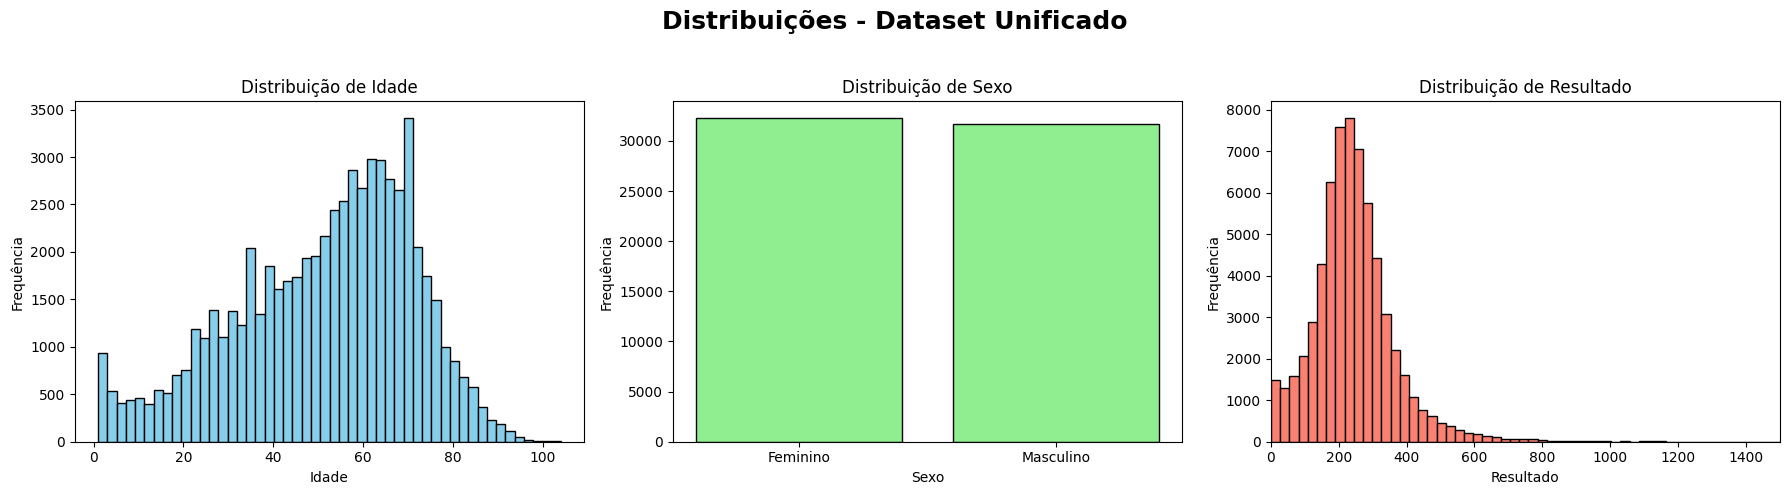

Dataset Unificado     Dataset 1     Dataset 2     Dataset 3
Idade     count       64061.000000  12104.000000  27971.000000  23986.000000
          mean           51.229921     51.718027     51.082049     51.156049
          std            19.922232     19.720020     20.248816     19.634748
          min             1.000000      1.000000      3.000000      1.000000
          25%            38.000000     39.000000     37.000000     38.000000
          50%            55.000000     55.000000     55.000000     54.000000
          75%            66.000000     66.000000     66.000000     66.000000
          max           104.000000    104.000000    104.000000    101.000000
Resultado count       64061.000000  12104.000000  27971.000000  23986.000000
          mean          243.820990    235.447455    250.145079    240.671744
          std           120.880569    119.084161    126.720440    114.248473
          min             1.000000      1.000000      1.000000      1.000000
          25%           175.000000    167.750000    179.000000    174.000000
          50%           233.000000    227.000000    237.000000    232.000000
          75%           298.000000    292.000000    303.000000    296.000000
          max          2708.000000   2708.000000   2626.000000   1410.000000

/home/henrique/Documentos/grad/EA998/A1/.venv/lib/python3.10/site-packages/seaborn/categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)
/home/henrique/Documentos/grad/EA998/A1/.venv/lib/python3.10/site-packages/seaborn/categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)
/home/henrique/Documentos/grad/EA998/A1/.venv/lib/python3.10/site-packages/seaborn/categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)
/home/henrique/Documentos/grad/EA998/A1/.venv/lib/python3.10/site-packages/seaborn/categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


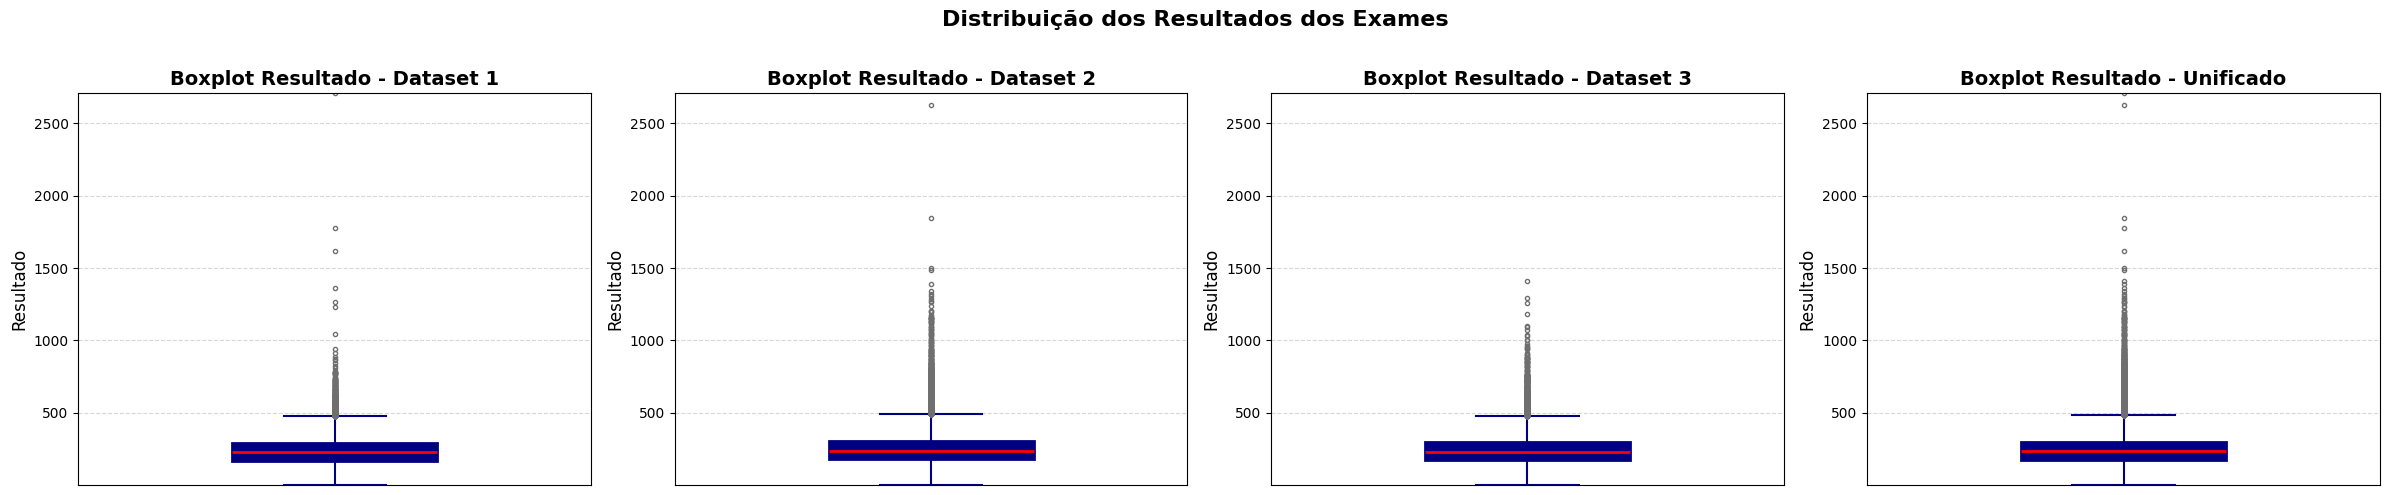

In [28]:
dados = pd.concat([data1, data2, data3], ignore_index=True)
dados.reset_index(drop=True, inplace=True)

plot_distributions(dados, "Distribuições - Dataset Unificado")
print_stats_all_tables([dados, data1, data2, data3], ["Dataset Unificado", "Dataset 1", "Dataset 2", "Dataset 3"])

plot_boxplots([data1, data2, data3, dados], ['Dataset 1', 'Dataset 2', 'Dataset 3', 'Unificado'])

In [29]:
def aplicar_umap(data, n_components=2):
    X = data.copy()
    X['sexo'] = X['sexo'].astype(float)
    X = X[['idade', 'sexo', 'resultado']]
    reducer = umap.UMAP(n_components=n_components)
    componentes = reducer.fit_transform(X)
    return componentes

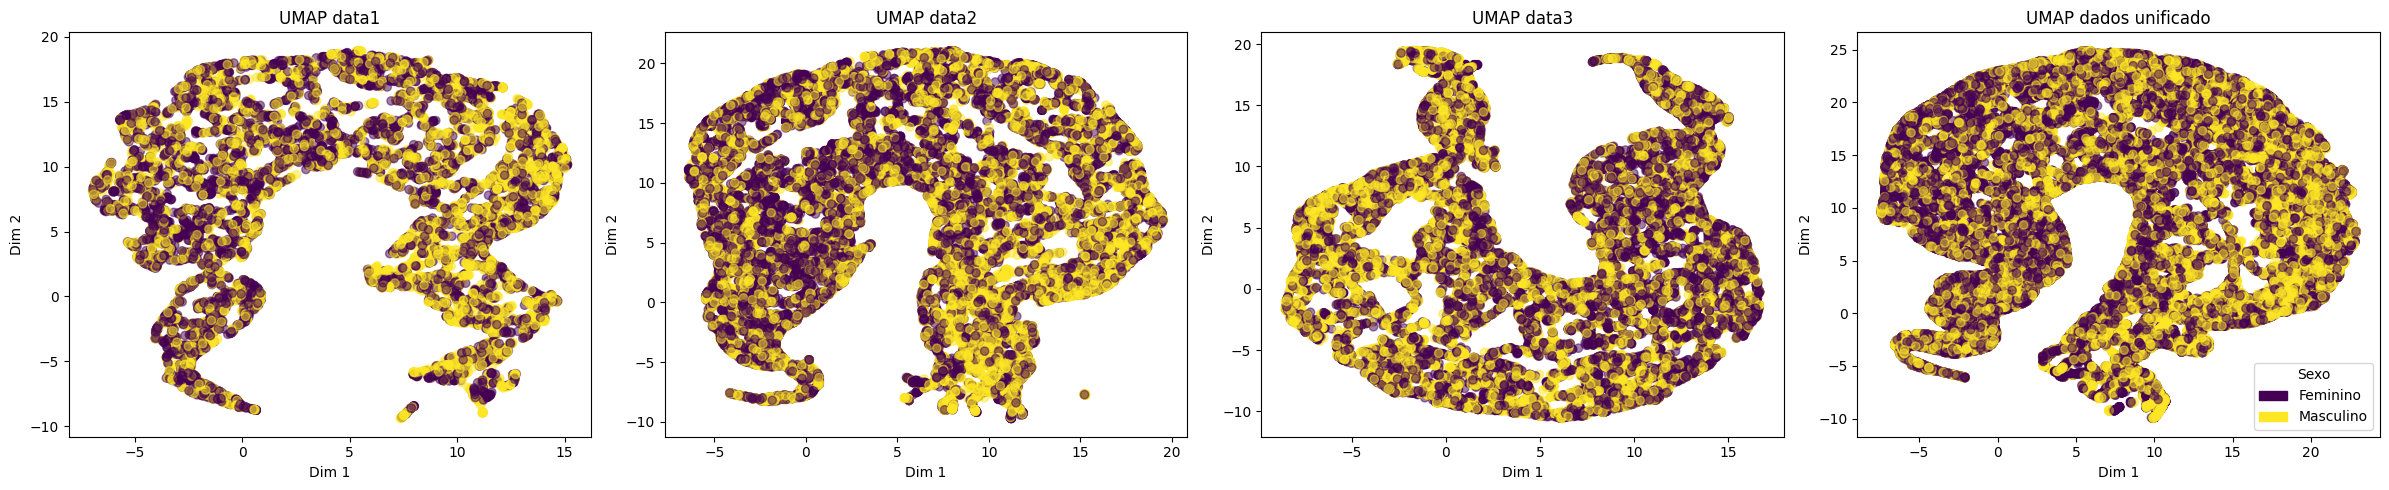

In [30]:
umap1 = aplicar_umap(data1)
umap2 = aplicar_umap(data2)
umap3 = aplicar_umap(data3)
umap_dados = aplicar_umap(dados)

fig, axes = plt.subplots(1, 4, figsize=(24, 5))

axes[0].scatter(umap1[:, 0], umap1[:, 1], c=data1["sexo"], cmap='viridis', alpha=0.5)
axes[0].set_title('UMAP data1')
axes[0].set_xlabel('Dim 1')
axes[0].set_ylabel('Dim 2')

axes[1].scatter(umap2[:, 0], umap2[:, 1], c=data2["sexo"], cmap='viridis', alpha=0.5)
axes[1].set_title('UMAP data2')
axes[1].set_xlabel('Dim 1')
axes[1].set_ylabel('Dim 2')

axes[2].scatter(umap3[:, 0], umap3[:, 1], c=data3["sexo"], cmap='viridis', alpha=0.5)
axes[2].set_title('UMAP data3')
axes[2].set_xlabel('Dim 1')
axes[2].set_ylabel('Dim 2')

axes[3].scatter(umap_dados[:, 0], umap_dados[:, 1], c=dados["sexo"], cmap='viridis', alpha=0.5)
axes[3].set_title('UMAP dados unificado')
axes[3].set_xlabel('Dim 1')
axes[3].set_ylabel('Dim 2')

handles = [
    mpatches.Patch(color=plt.cm.viridis(0.0), label='Feminino'),
    mpatches.Patch(color=plt.cm.viridis(1.0), label='Masculino')
]
axes[3].legend(handles=handles, title='Sexo')

plt.tight_layout()
plt.show()

Observa-se que o dataset unificado de fato mantém a distribuição dos datasets originais. Além disso, o UMAP indica que a distribuição dos dados por sexo no conjunto unificado é semelhante à observada nos datasets originais.

In [31]:
dados_reais, dados_teste = train_test_split(dados, test_size=0.2, shuffle=True)
print(f"Tamanho treino: {len(dados_reais)} ({len(dados_reais)/len(dados)*100:.2f}%)")
print(f"Tamanho teste: {len(dados_teste)} ({len(dados_teste)/len(dados)*100:.2f}%)")

Tamanho treino: 51248 (80.00%)
Tamanho teste: 12813 (20.00%)


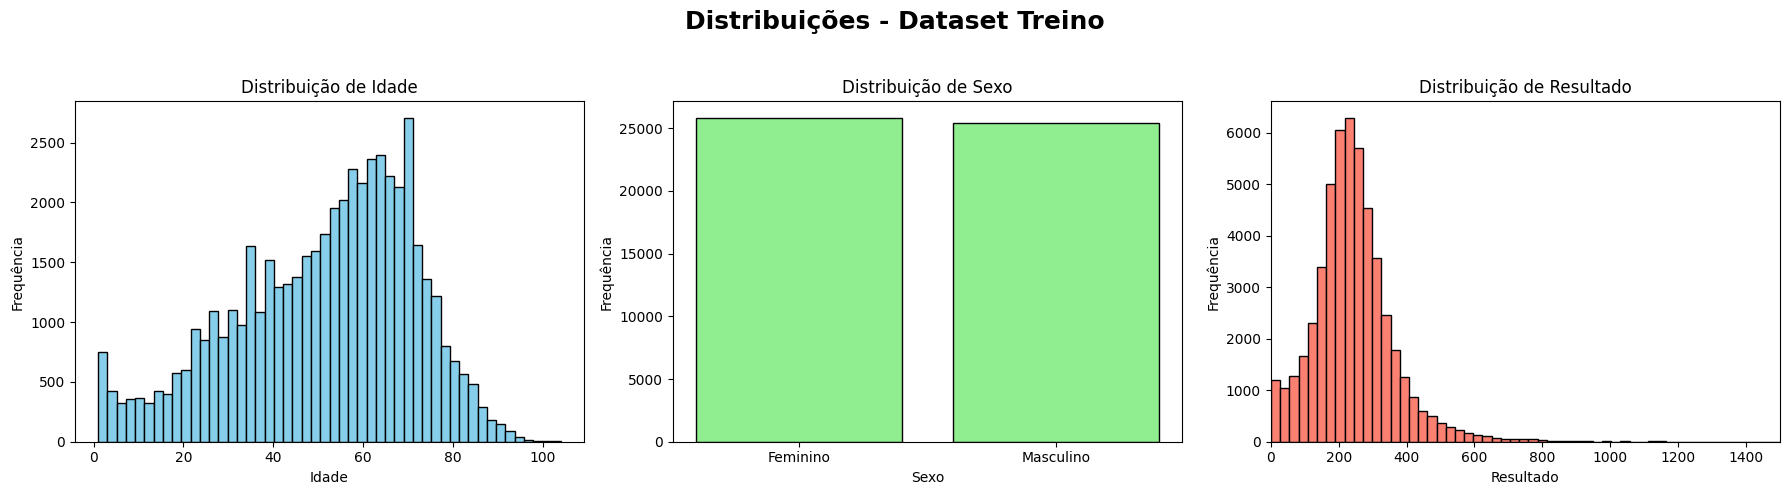

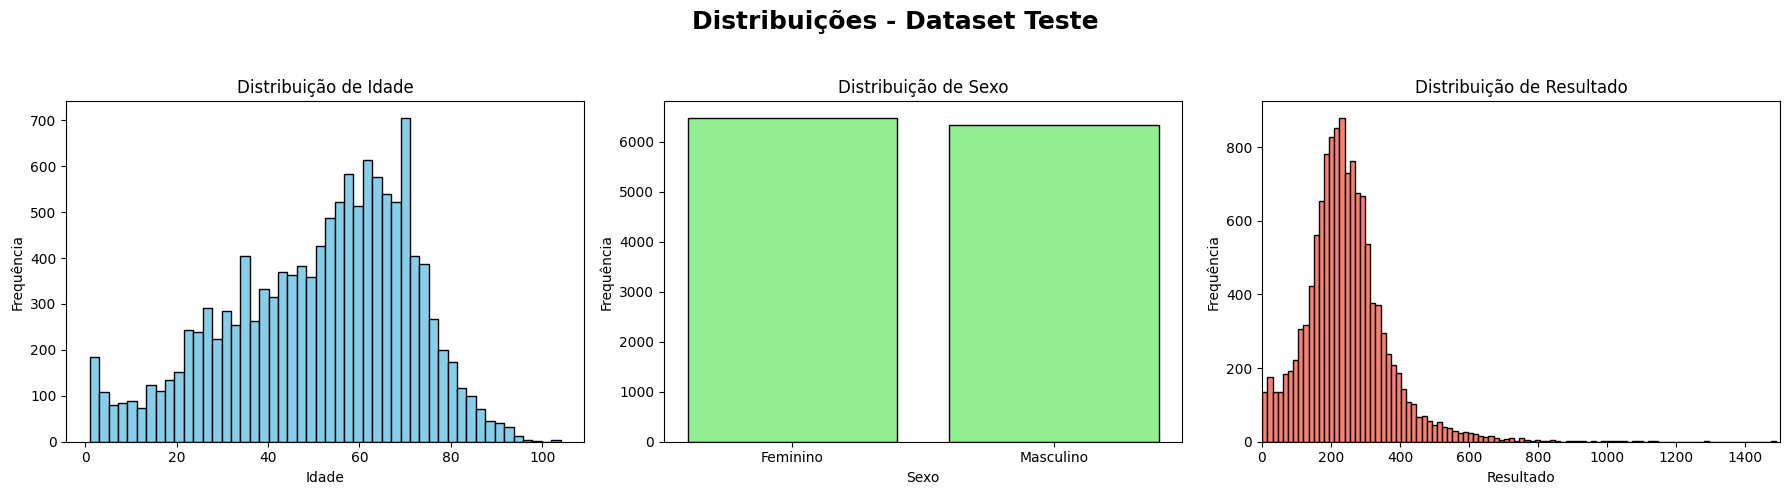

Dataset Unificado  Dataset Treino  Dataset Teste
Idade     count       64061.000000    51248.000000   12813.000000
          mean           51.229921       51.265747      51.086631
          std            19.922232       19.916132      19.946744
          min             1.000000        1.000000       1.000000
          25%            38.000000       38.000000      37.000000
          50%            55.000000       55.000000      55.000000
          75%            66.000000       66.000000      66.000000
          max           104.000000      104.000000     104.000000
Resultado count       64061.000000    51248.000000   12813.000000
          mean          243.820990      243.737540     244.154765
          std           120.880569      121.190217     119.638173
          min             1.000000        1.000000       1.000000
          25%           175.000000      175.000000     174.000000
          50%           233.000000      233.000000     233.000000
          75%           298.000000      298.000000     298.000000
          max          2708.000000     2708.000000    1489.000000

In [32]:
plot_distributions(dados_reais, "Distribuições - Dataset Treino")
plot_distributions(dados_teste, "Distribuições - Dataset Teste")

print_stats_all_tables([dados, dados_reais, dados_teste], ["Dataset Unificado", "Dataset Treino", "Dataset Teste"])

Também observamos que o split mantém a distribuição semelhante à original. Como ainda há variação considerável entre os campos "Resultados" do treino e do teste, temos um conjunto de teste relevante para avaliar o dataset sintético.

# 2. Proposta modelo de síntese

Para o modelo de geração de dados, optou-se pelo uso do bootstrap, uma clássica abordagem estatística de reamostragem caracterizada pela criação de novas amostras a partir do sorteio, com reposição, dos dados originais.

No contexto deste problema, esta abordagem é aplicada para reamostrar a idade e o resultado dos exame de plaquetas. Ao invés de assumir uma distribuição, o método sorteia 10.000 amostras com reposição dos valores observados e adiciona um pequeno ruído previamente definido (10% desvio padrão), garantindo variabilidade da nova população e mantendo a distribuição anterior.

O bootstrap foi implementado considerando a estratificação por sexo e idade. Para cada estrato, são sorteadas amostras dos valores reais de idade e resultado do exame, com adição de ruído. As idades geradas foram truncadas para ficarem na faixa de idades original.

In [39]:
bins = [0, 20, 40, 60, 80, 120]
labels = ["0-19", "20-39", "40-59", "60-79", "80+"]
dados_reais["faixa_idade"] = pd.cut(dados_reais["idade"], bins=bins, labels=labels, right=False)
dados_teste["faixa_idade"] = pd.cut(dados_teste["idade"], bins=bins, labels=labels, right=False)

synthetic_data = []
n_samples = 10000
ruido_perc = 0.1

df = dados_reais.copy()
df["resultado"] = df["resultado"].astype(float)

for (sexo, faixa), grupo in df.groupby(["sexo", "faixa_idade"]):
    if len(grupo) != 0:    
        
        n_estrato = int(n_samples * (len(grupo)/len(df)))
        
        # plaquetas
        sampled_resultados = np.random.choice(grupo["resultado"], size=n_estrato, replace=True)
        ruido_resultados = np.random.normal(0, grupo["resultado"].std() * ruido_perc, size=n_estrato)
        synthetic_resultados = np.clip(sampled_resultados + ruido_resultados, 0, 1200)

        # idades
        sampled_idades = np.random.choice(grupo["idade"], size=n_estrato, replace=True)
        ruido_idades = np.random.normal(0, grupo["idade"].std() * ruido_perc, size=n_estrato)
        synthetic_idades = sampled_idades + ruido_idades
        
        # truncar idades
        faixa_idx = labels.index(faixa)
        faixa_min = bins[faixa_idx]
        faixa_max = bins[faixa_idx + 1] - 1
        synthetic_idades = np.clip(synthetic_idades, faixa_min, faixa_max)
        synthetic_idades = synthetic_idades.round().astype(int)

        for idade, resultado in zip(synthetic_idades, synthetic_resultados):
            synthetic_data.append({"idade": idade, "sexo": sexo, "resultado": resultado})

dados_sinteticos = pd.DataFrame(synthetic_data)
dados_sinteticos.head()

/tmp/ipykernel_5323/779662464.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (sexo, faixa), grupo in df.groupby(["sexo", "faixa_idade"]):


,idade,sexo,resultado
0,15,0,280.941235
1,4,0,444.316223
2,8,0,335.202106
3,13,0,186.217686
4,19,0,215.052599


# 3. Avaliação dos dados sintéticos

Para assegurar a qualidade dos novos dados gerados, serão feitas análises baseadas na comparação das distruições estatísticas dos datasets de treino, de teste e o sintético, levando em consideração idade, sexo e resultado do exame de plaquetas. Além disso, será utilizada redução de dimensionalidade para complementar a visulaização da proximidade do dataset gerado com os originais. Por fim, também serão contemplados testes estatísticos como o Teste Kolmogorov-Smirnov e a Distância de Wasserstein.

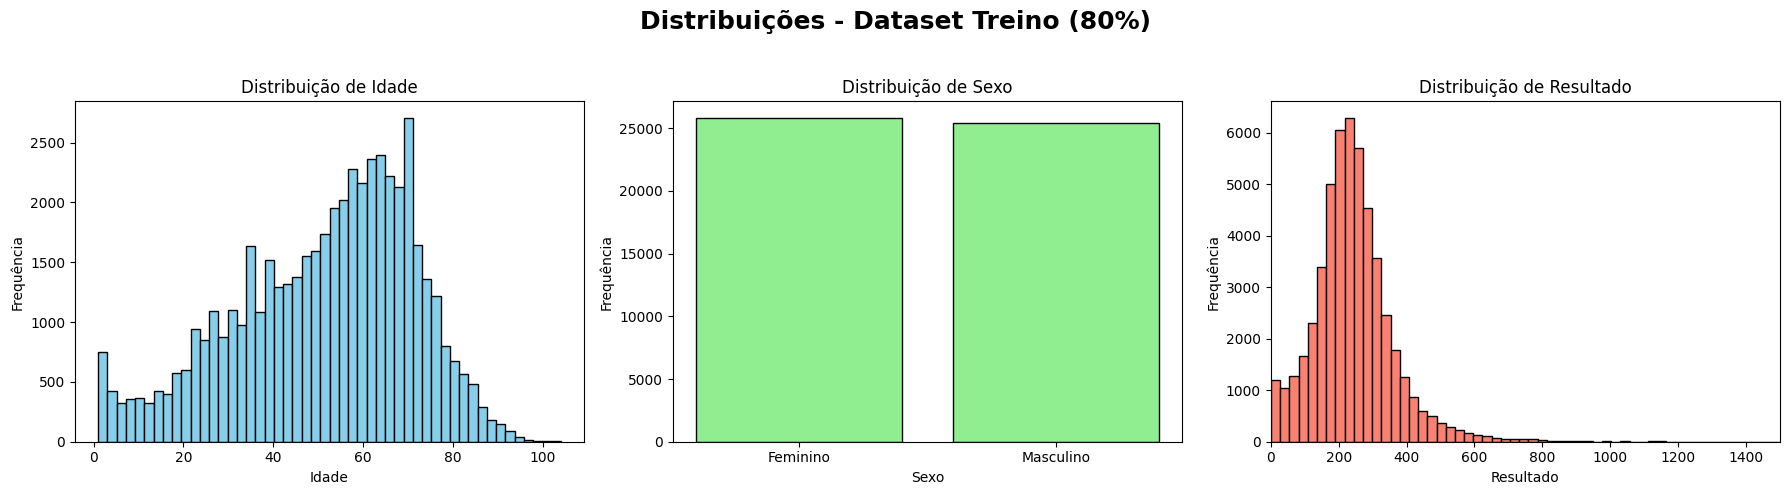

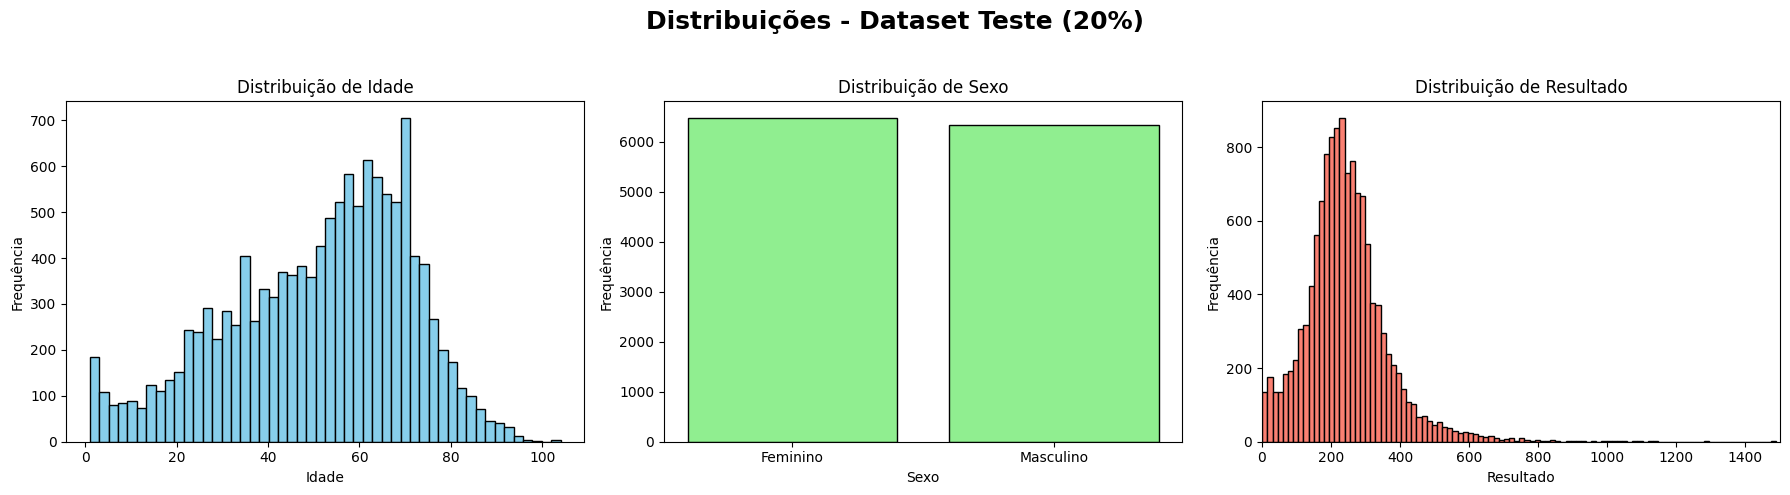

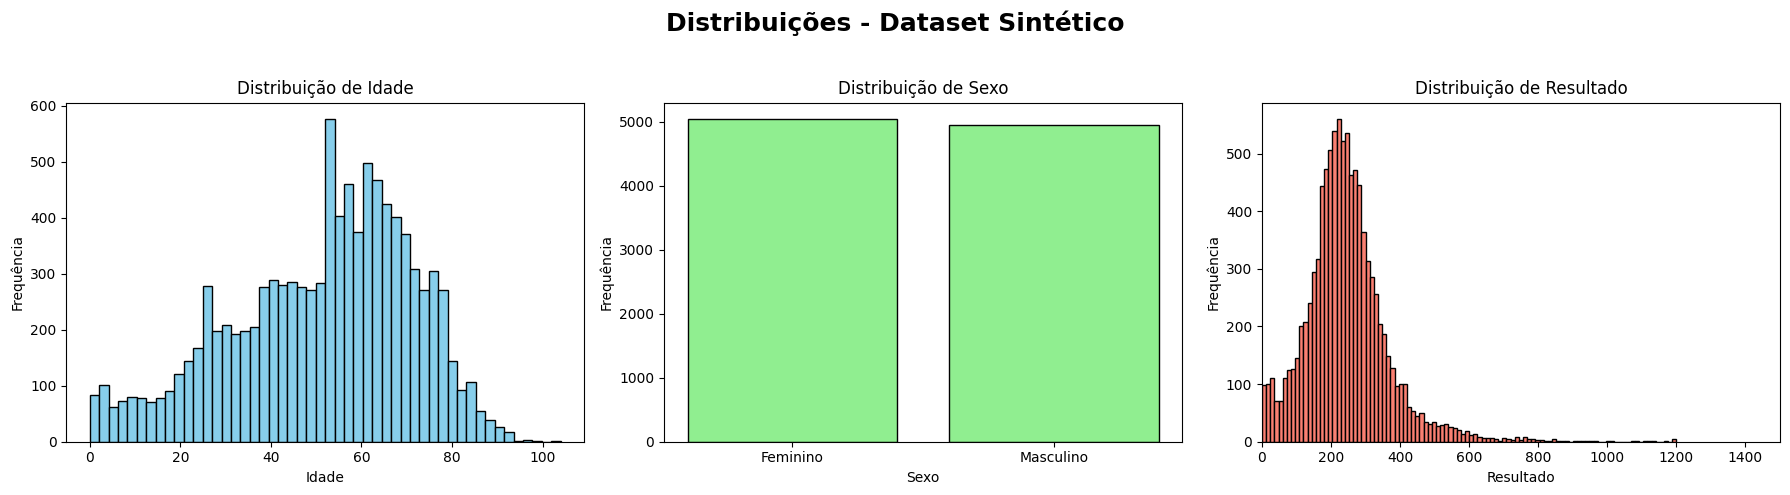

Dataset Treino (80%)  Dataset Sintético  Dataset Teste (20%)
Idade     count          51248.000000        9996.000000         12813.000000
          mean              51.265747          51.257103            51.086631
          std               19.916132          19.913684            19.946744
          min                1.000000           0.000000             1.000000
          25%               38.000000          38.000000            37.000000
          50%               55.000000          55.000000            55.000000
          75%               66.000000          66.000000            66.000000
          max              104.000000         104.000000           104.000000
Resultado count          51248.000000        9996.000000         12813.000000
          mean             243.737540         244.836382           244.154765
          std              121.190217         121.531892           119.638173
          min                1.000000           0.000000             1.000000
          25%              175.000000         174.844649           174.000000
          50%              233.000000         233.932984           233.000000
          75%              298.000000         298.638933           298.000000
          max             2708.000000        1200.000000          1489.000000

/home/henrique/Documentos/grad/EA998/A1/.venv/lib/python3.10/site-packages/seaborn/categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)
/home/henrique/Documentos/grad/EA998/A1/.venv/lib/python3.10/site-packages/seaborn/categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)
/home/henrique/Documentos/grad/EA998/A1/.venv/lib/python3.10/site-packages/seaborn/categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


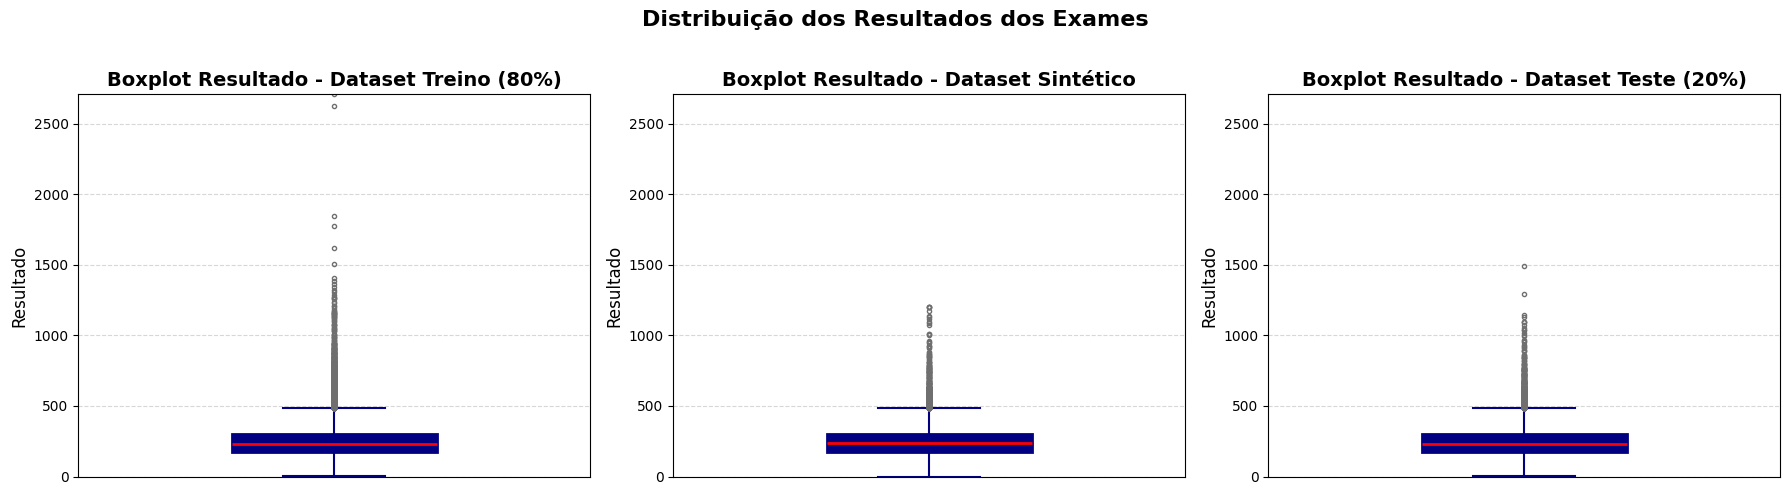

In [40]:
plot_distributions(dados_reais, "Distribuições - Dataset Treino (80%)")
plot_distributions(dados_teste, "Distribuições - Dataset Teste (20%)")
plot_distributions(dados_sinteticos, "Distribuições - Dataset Sintético")

print_stats_all_tables([dados_reais, dados_sinteticos, dados_teste], ["Dataset Treino (80%)", "Dataset Sintético", "Dataset Teste (20%)"])
plot_boxplots([dados_reais, dados_sinteticos, dados_teste], ['Dataset Treino (80%)', 'Dataset Sintético', 'Dataset Teste (20%)'])

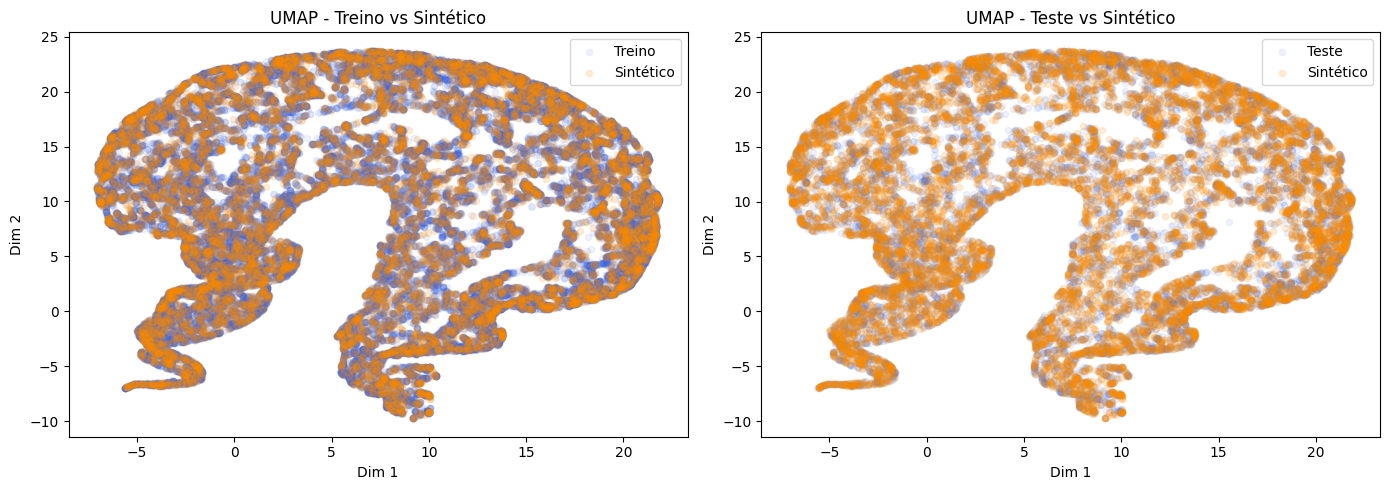

In [41]:
reducer = umap.UMAP(n_components=2)
reducer.fit(dados_reais[['idade', 'sexo', 'resultado']].astype(float))

umap_treino = reducer.transform(dados_reais[['idade', 'sexo', 'resultado']].astype(float))
umap_sintetico = reducer.transform(dados_sinteticos[['idade', 'sexo', 'resultado']].astype(float))
umap_teste = reducer.transform(dados_teste[['idade', 'sexo', 'resultado']].astype(float))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(umap_treino[:, 0], umap_treino[:, 1], c='royalblue', alpha=0.08, s=20)
axes[0].scatter(umap_sintetico[:, 0], umap_sintetico[:, 1], c='darkorange', alpha=0.15, s=20)
axes[0].set_title('UMAP - Treino vs Sintético')
axes[0].set_xlabel('Dim 1')
axes[0].set_ylabel('Dim 2')
axes[0].legend(['Treino', 'Sintético'], loc='upper right')

axes[1].scatter(umap_teste[:, 0], umap_teste[:, 1], c='royalblue', alpha=0.08, s=20)
axes[1].scatter(umap_sintetico[:, 0], umap_sintetico[:, 1], c='darkorange', alpha=0.15, s=20)
axes[1].set_title('UMAP - Teste vs Sintético')
axes[1].set_xlabel('Dim 1')
axes[1].set_ylabel('Dim 2')
axes[1].legend(['Teste', 'Sintético'], loc='upper right')

plt.tight_layout()
plt.show()

In [42]:
# teste ks
ks_stat, ks_p = ks_2samp(dados_teste["resultado"].astype(float), dados_sinteticos["resultado"].astype(float))
print(f"KS test: estatística={ks_stat:.3f}, p-valor={ks_p:.3f}")

# distancia wasserstein
wdist = wasserstein_distance(dados_teste["resultado"], dados_sinteticos["resultado"])
print(f"Distância Wasserstein: {wdist:.3f}")

KS test: estatística=0.010, p-valor=0.605
Distância Wasserstein: 1.519


In [43]:
dados_sinteticos.to_csv('dados_sinteticos.csv', index=False)

A partir dos plots de distribuição e dos dados estatísticos apresentados, inferimos que os dados sintéticos são capazes de reproduzir satisfatoriamente a distribuição original, tanto a de treino como a de teste, introduzindo uma ruído desejável para diversificação dos dados. Esta observação é corroborada pelo UMAP, que mostra visualmente o fenômeno da reprodução da distribuição com introdução de variabilidade da população. 

A partir do teste KS, que mede a distância das distribuições por meio da maior diferença presente nas distribuições acumuladas, notamos que as distribuições sintética e de treino possuem uma distância muito baixa, ou seja, elas são próximas. Já o p-valor>>0.05 torna robusta a hipótese de que as distribuições não são diferentes entre si.

Por fim, temos que a Distância de Wasserstein, que mede a área total entre as distribuições acumuladas, possui um valor baixo, indicando novamente a proximidade das duas distribuições.

Considerando a convergência dos resultados de todos estes indicadores, concluímos que o método foi capaz de sintetizar dados relevantes de exames, preservando a forma original dos dados e criando maior variabilidade (fator esse que pode ser ajustado através do noise rate). Uma limitação importante é que este método não foi capaz de preencher certos gaps presentes no dataset original, evidenciando a tendência deste método a imitar os dados originais. Isso pode se tornar um problema, por exemplo, para datasets de origem com poucos dados ou com a presença de viéses. Métodos como Signal and Noise podem mitigar este efeito, ao gerar dados mais distantes e especializados.  